## Estimating functional connectivity from resting fMRI data

In this notebook we will examine how to estimate connectivity matrices from resting fMRI data, using data from the myconnectome project.

In [40]:
import os
import numpy,pandas
import matplotlib.pyplot as plt
%matplotlib inline

datadir='data/myconnectome'

parceldata=pandas.read_csv(os.path.join(datadir,'parcel_data.txt'),
                           header=None,sep='\t')
parceldata.columns=['num','hemis','X','Y','Z','lobe','sublobe',
                    'power','yeo7','yeo17']

Let's load the data from a single session and prepare it for analysis.

In [13]:
subcode='sub014'
# load the timeseries data
tsdata = numpy.loadtxt(os.path.join(datadir,'combined_data_scrubbed/%s.txt'%subcode))

# rows are timepoints, columns are ROIs
print('before masking')
print(tsdata.shape)

# load the timeseries mask - to remove bad timepoints
tsmask=numpy.loadtxt(os.path.join(datadir,'tmasks/%s.txt'%subcode))

tsdata_masked=tsdata[tsmask==1,:]

print('after masking')
print(tsdata_masked.shape)

# make sure that the parceldata and tsdata match
assert tsdata_masked.shape[1] == parceldata.shape[0]


before masking
(518, 630)
after masking
(505, 630)


Start by just plotting the data using a carpet plot

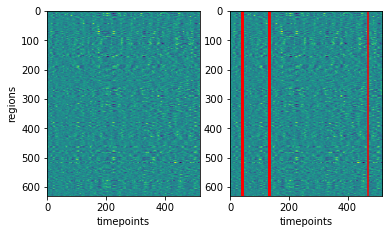

In [32]:
plt.subplot(1,2,1)
plt.imshow(tsdata.T)
plt.xlabel('timepoints')
plt.ylabel('regions')
plt.subplot(1,2,2)
plt.imshow(tsdata.T)
plt.xlabel('timepoints')
for i in numpy.where(tsmask==0)[0]:
    plt.plot([i,i],[0.,629],color='r')

### Computing functional connectivity: correlation

We generally compute functional connectivity using the correlation coefficient.  Let's compute that on the timeseries, using the masked data.

In [35]:
tscorr=numpy.corrcoef(tsdata_masked.T)
tscorr.shape

(630, 630)

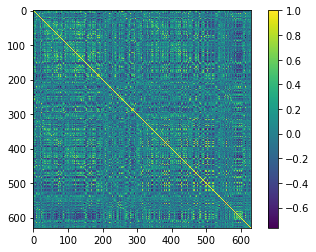

In [115]:
plt.imshow(tscorr)
plt.colorbar()

It's clear from looking at the data that there is substantial structure in the correlations.  To see this more clearly, let's reorganize the data using the network assignments that were given to the regions on the basis of resting state correlation structure.  First let's look at the Power et al. networks.


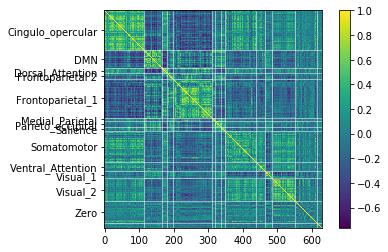

In [116]:
def reorder_corrs(corrmtx,parceldata,labels='power'):
    """
    reorder correlation matrix according to network labels
    """
    idx=numpy.argsort(parceldata[labels])
    tmp=corrmtx[:,idx]
    return(tmp[idx,:],parceldata.iloc[idx,:])

def plot_reordered_corrs(corrmtx,parceldata,labels='power'):
    """
    plot correlation matrix after reordering
    """

    corr_reord,parceldata_reord=reorder_corrs(corrmtx,parceldata,labels)
    plt.imshow(corr_reord)
    # find breakpoints and plot lines
    breaks=numpy.array([int(not i) for i in parceldata_reord[labels].values[:-1]==parceldata_reord[labels].values[1:]])
    breaklocs=numpy.where(breaks)[0]
    for b in breaklocs:
        plt.plot([0,corrmtx.shape[0]-1],[b,b],color='w',linewidth=0.5)
        plt.plot([b,b],[0,corrmtx.shape[0]-1],color='w',linewidth=0.5)
    # find label locations
    # add a zero to help find label locations 
    breaklocs2=numpy.hstack(([0],breaklocs))
    label_locs=numpy.mean(numpy.vstack((breaklocs,breaklocs2[:-1])),0)
    networks=parceldata_reord['power'].values[breaklocs]
    ax=plt.gca()
    ax.set_yticks(label_locs)
    ax.set_yticklabels(networks)
    plt.colorbar()

plot_reordered_corrs(tscorr,parceldata)

### Partial correlation

Correlation is sensitive both to direct connections between regions as well as indirect connections.  Instead we might be interested in direct connections only, which can be estimated using partial correlation (also known as inverse covariance). Let's estimate that using the graphical lasso technique, which uses L1 regularization that imposes sparsity on the solution (i.e. many of the entries are zero).  

In [137]:
from sklearn.covariance import GraphLassoCV
estimator = GraphLassoCV()

In [138]:
estimator.fit(tsdata_masked)  

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

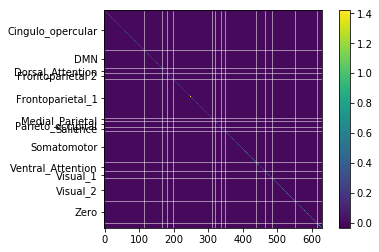

In [141]:
plot_reordered_corrs(estimator.precision_,parceldata)